In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from mindreadingautobots.sequence_generators import make_datasets, data_io
from mindreadingautobots.entropy_and_bayesian import entropy
import time

import gspread
from google.oauth2.service_account import Credentials


In [2]:
# Path to your service account JSON file
SERVICE_ACCOUNT_FILE = "../velvety-tube-450516-r5-2dfa430c056c.json" 


# Define the scope (Google Sheets + Google Drive API)
SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive.file",  # Allows access to files the service account has access to
    "https://www.googleapis.com/auth/drive.readonly"  # Read-only access to drive files
]
# Authenticate with Google
creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
client = gspread.authorize(creds)

# Open the spreadsheet
SPREADSHEET_NAME = "sparse_parity_21_4"
spreadsheet = client.open(SPREADSHEET_NAME)

In [18]:
# Get names of all sheets
sheet_names = [sheet.title for sheet in spreadsheet.worksheets()]
name_to_idx = {}
for i, name in enumerate(sheet_names):
    name_to_idx[name] = i
print("Sheets in the spreadsheet:")
for name in sheet_names:
    print(f"  {name}")

# transformer_template = 'SAN_sparse_parity_k4_nbits21_n2000_bf{}_seed1234'
# rnn_template = 'RNN_sparse_majority_k5_nbits21_n2000_bf{}_seed1234'
# bf_vals = list(range(0, 50, 5))
bf_vals = [0, 1, 2, 5, 7.5, 10, 12.5, 15, 17.5, 20]
best_n = 1
df_dct = {
    "RNN": {}, 
    "SAN": {}
            }

best_dct = {
    "RNN": {"noiseless": [], "noisy": [], "train_acc": []}, 
    "SAN": {"noiseless": [], "noisy": [], "train_acc": []}
            }

for k in best_dct.keys():
    sheetname_template = '{}_sparse_parity_k4_nbits21_n5000_bf{}_seed1234'
    for bf in bf_vals:
        target = sheetname_template.format(k, bf)
        target_idx = name_to_idx.get(target)
        print("Loading:", target)
        if target_idx is None:
            raise ValueError(f"Sheet {target} not found.")
        sheet = spreadsheet.get_worksheet(target_idx)
        data = sheet.get_all_records()
        print(data)
        df = pd.DataFrame(data)
        df_dct[k][bf] = df
        best_noiseless = df.sort_values(by='val_acc', ascending=False).head(best_n)['noiseless_val_acc'].to_numpy()
        best_noisy = df.sort_values(by='val_acc', ascending=False).head(best_n)['val_acc'].to_numpy()
        best_train_acc = df.sort_values(by='val_acc', ascending=False).head(best_n)['train_acc'].to_numpy()
        best_dct[k]["noiseless"].append(best_noiseless)
        best_dct[k]["noisy"].append(best_noisy)
        best_dct[k]["train_acc"].append(best_train_acc)



Sheets in the spreadsheet:
  SAN_sparse_parity_k4_nbits21_n5000_bf1_seed1234
  SAN_sparse_parity_k4_nbits21_n5000_bf5_seed1234
  RNN_sparse_parity_k4_nbits21_n5000_bf0_seed1234
  RNN_sparse_parity_k4_nbits21_n5000_bf10_seed1234
  RNN_sparse_parity_k4_nbits21_n5000_bf20_seed1234
  SAN_sparse_parity_k4_nbits21_n5000_bf0_seed1234
  SAN_sparse_parity_k4_nbits21_n5000_bf10_seed1234
  SAN_sparse_parity_k4_nbits21_n5000_bf20_seed1234
  RNN_sparse_parity_k4_nbits21_n5000_bf1_seed1234
  RNN_sparse_parity_k4_nbits21_n5000_bf2_seed1234
  RNN_sparse_parity_k4_nbits21_n5000_bf5_seed1234
  SAN_sparse_parity_k4_nbits21_n5000_bf7.5_seed1234
  SAN_sparse_parity_k4_nbits21_n5000_bf12.5_seed1234
  SAN_sparse_parity_k4_nbits21_n5000_bf15_seed1234
  SAN_sparse_parity_k4_nbits21_n5000_bf17.5_seed1234
  RNN_sparse_parity_k4_nbits21_n5000_bf12.5_seed1234
  RNN_sparse_parity_k4_nbits21_n5000_bf7.5_seed1234
  RNN_sparse_parity_k4_nbits21_n5000_bf17.5_seed1234
  RNN_sparse_parity_k4_nbits21_n5000_bf15_seed1234
 

In [20]:

all_H = []
all_mle = []
p_bitflips = [bf / 100 for bf in bf_vals]
def sparity_k4(n_data, n_bits, p_bitflip, seed, subseq_idx=None):
    """Wrapper for sparse_parity_k_n with k=4"""
    return make_datasets.sparse_parity_k_n(n_bits, 4, n_data, p_bitflip, seed, subseq_idx=subseq_idx)

# Generate data with bitflip values
seed = 1234 
n_data = 100000 # ~maximum~ amount of data to analyze
inc = 50000 # increment at which to check convergence
assert inc < n_data
n_bits = 5 # HACK: We only consider the bits that actually contribute to the majority vote
intermediate_idx = list(range(inc, n_data, inc))

all_H = []
all_mle_noisy = []
all_mle_noiseless = []

for i in range(len(p_bitflips)):
    t0 = time.time()
    X, Z, idx = sparity_k4(n_data, n_bits, p_bitflips[i], seed)
    print("generated data for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    t0 = time.time()
    # compute the mle performance and the mle lookup table for this dataset
    H_results, mle_results, lookup_results = entropy.empirical_entropy_estimate(Z, intermediate_idx=intermediate_idx)
    print("computed entropy for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    all_H.append(H_results)
    all_mle_noisy.append(mle_results)
    # compute the accuracy of MLE(trained on noisy) predicting the noiseless data
    t0 = time.time()
    mle_noiseless = entropy.compute_mle_with_lookup(X, lookup_results[-1])
    print("computed noiseless MLE for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    all_mle_noiseless.append(mle_noiseless)

generated data for p_bitflip =  0.0  took  0.6803286075592041  seconds
computed entropy for p_bitflip =  0.0  took  0.0923621654510498  seconds
computed noiseless MLE for p_bitflip =  0.0  took  0.20332026481628418  seconds
generated data for p_bitflip =  0.01  took  0.5541026592254639  seconds
computed entropy for p_bitflip =  0.01  took  0.09603762626647949  seconds
computed noiseless MLE for p_bitflip =  0.01  took  0.18886995315551758  seconds
generated data for p_bitflip =  0.02  took  0.5077998638153076  seconds
computed entropy for p_bitflip =  0.02  took  0.09223031997680664  seconds
computed noiseless MLE for p_bitflip =  0.02  took  0.21776652336120605  seconds
generated data for p_bitflip =  0.05  took  0.5582542419433594  seconds
computed entropy for p_bitflip =  0.05  took  0.0898885726928711  seconds
computed noiseless MLE for p_bitflip =  0.05  took  0.19648218154907227  seconds
generated data for p_bitflip =  0.075  took  0.5552983283996582  seconds
computed entropy for

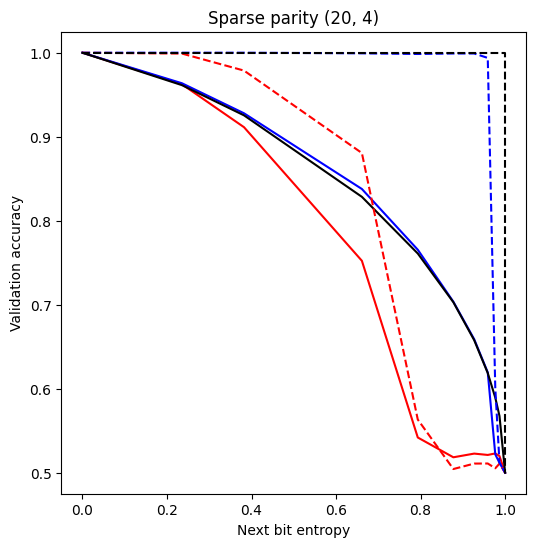

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
def append_last(x, y):
    # return (x, y) # WARNING
    return np.concatenate((x, [1])).flatten(), np.concatenate((y, [0.5])).flatten()

xvals = np.array([x[-1] for x in all_H])
# xvals = p_bitflips

mle_noisy_final = np.array([x[-1] for x in all_mle_noisy])

rnn_noiseless = np.array(best_dct["RNN"]["noiseless"]).flatten()
rnn_noisy = np.array(best_dct["RNN"]["noisy"]).flatten()
san_noiseless = np.array(best_dct["SAN"]["noiseless"]).flatten()
san_noisy = np.array(best_dct["SAN"]["noisy"]).flatten()

axes.plot(*append_last(xvals, rnn_noisy), label='LSTM', c='r', ls='-')
axes.plot(*append_last(xvals, san_noisy), label='Transformer', c='b', ls='-')
axes.plot(*append_last(xvals, mle_noisy_final), label='Optimal ', c='k', ls='-')

axes.plot(*append_last(xvals, rnn_noiseless), label='LSTM [noiseless]', c='r', ls='--')
axes.plot(*append_last(xvals, san_noiseless), label='Transformer [noiseless]', c='b', ls='--')
axes.plot([0, 1, 1], [1, 1, 0.5], label='Optimal [noiseless]', c='k', ls='--')
# plot the noiseless mle by hand


######
# axes.set_xlim(0, 0.2)

# axes.plot([0, 0.5, 0.5], [1, 1, 0.5], label='MLE [noiseless]', c='k', ls='-')
leg_prop = {'size': 10}
# axes.legend(prop=leg_prop, framealpha=1, bbox_to_anchor=(0.02, 0.02), loc='lower left')
axes.set_xlabel('Next bit entropy')
axes.set_ylabel('Validation accuracy')
axes.set_title('Sparse parity (20, 4)')
print()
# axes.plot(np.repeat(bf_vals, best_n), best_dct["RNN"].flatten(), axis=1, label='RNN')
# axes.plot(np.repeat(bf_vals, best_n), best_dct["SAN"].flatten(), axis=1, label='SAN')

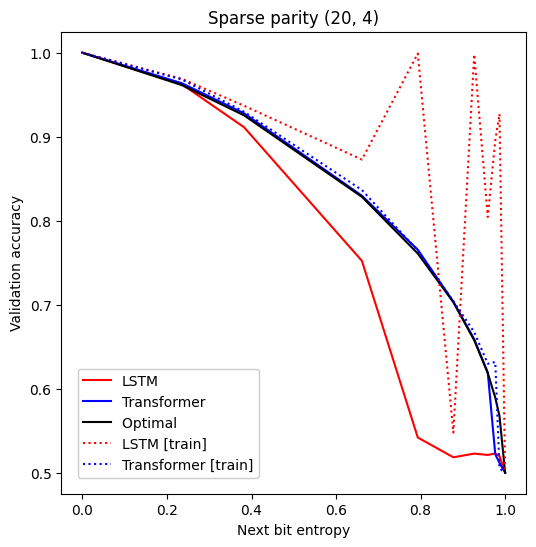

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
def append_last(x, y):
    # return (x, y) # WARNING
    return np.concatenate((x, [1])).flatten(), np.concatenate((y, [0.5])).flatten()

xvals = np.array([x[-1] for x in all_H])
mle_noisy_final = np.array([x[-1] for x in all_mle_noisy])
# xvals = p_bitflips

rnn_noiseless = np.array(best_dct["RNN"]["noiseless"]).flatten()
rnn_noisy = np.array(best_dct["RNN"]["noisy"]).flatten()
rnn_train = np.array(best_dct["RNN"]["train_acc"]).flatten()
san_noiseless = np.array(best_dct["SAN"]["noiseless"]).flatten()
san_noisy = np.array(best_dct["SAN"]["noisy"]).flatten()
san_train = np.array(best_dct["SAN"]["train_acc"]).flatten()

axes.plot(*append_last(xvals, rnn_noisy), label='LSTM', c='r', ls='-')
axes.plot(*append_last(xvals, san_noisy), label='Transformer', c='b', ls='-')
axes.plot(*append_last(xvals, mle_noisy_final), label='Optimal ', c='k', ls='-')

# axes.plot(*append_last(xvals, rnn_noiseless), label='LSTM [noiseless]', c='r', ls='--')
# axes.plot(*append_last(xvals, san_noiseless), label='Transformer [noiseless]', c='b', ls='--')
# axes.plot([0, 1, 1], [1, 1, 0.5], label='Optimal [noiseless]', c='k', ls='--')
axes.plot(*append_last(xvals, rnn_train), label='LSTM [train]', c='r', ls=':')
axes.plot(*append_last(xvals, san_train), label='Transformer [train]', c='b', ls=':')
# plot the noiseless mle by hand


# axes.plot([0, 0.5, 0.5], [1, 1, 0.5], label='MLE [noiseless]', c='k', ls='-')
leg_prop = {'size': 10}
axes.legend(prop=leg_prop, framealpha=1, bbox_to_anchor=(0.02, 0.02), loc='lower left')
axes.set_xlabel('Next bit entropy')
axes.set_ylabel('Validation accuracy')
axes.set_title('Sparse parity (20, 4)')
print()
# axes.plot(np.repeat(bf_vals, best_n), best_dct["RNN"].flatten(), axis=1, label='RNN')
# axes.plot(np.repeat(bf_vals, best_n), best_dct["SAN"].flatten(), axis=1, label='SAN')

### Histogram of training accuracies..?


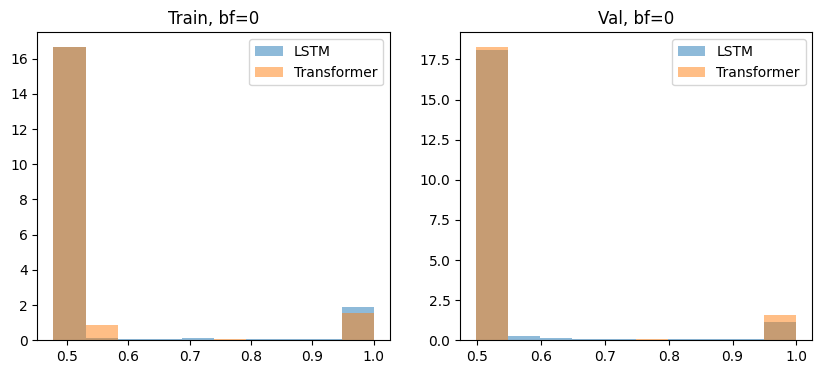

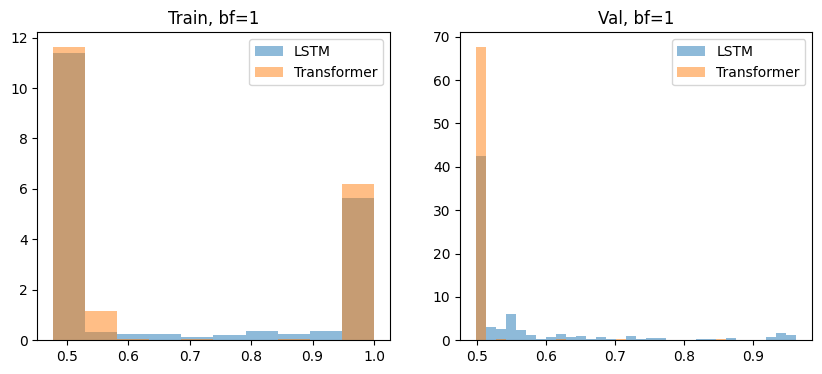

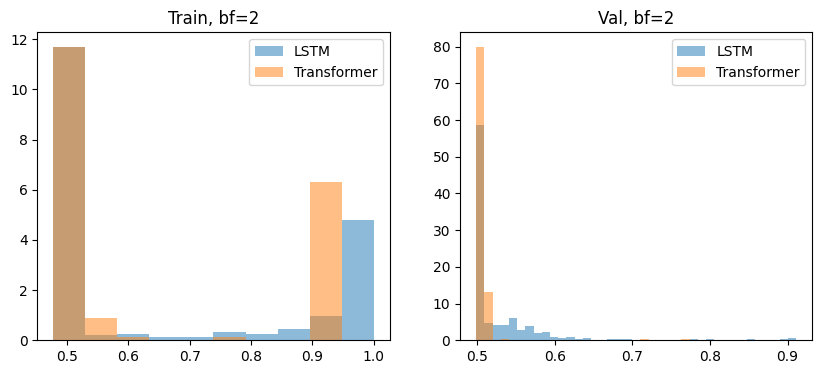

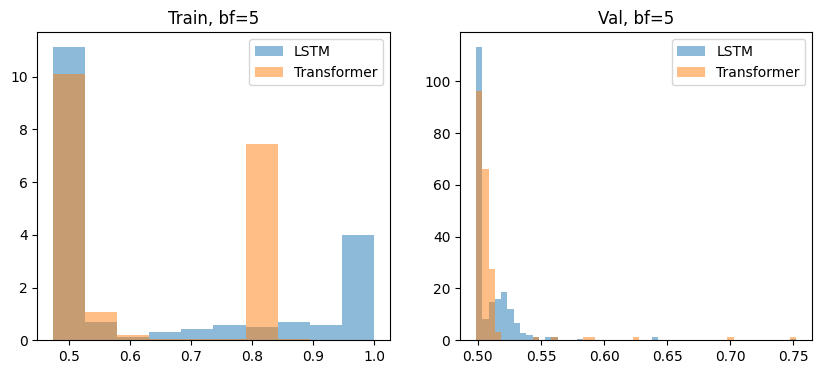

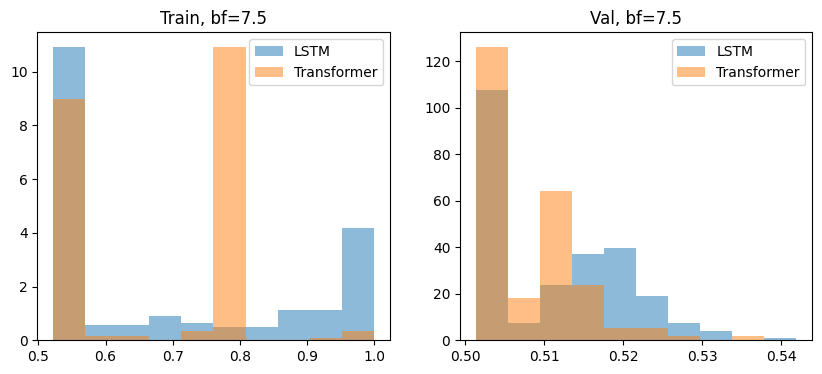

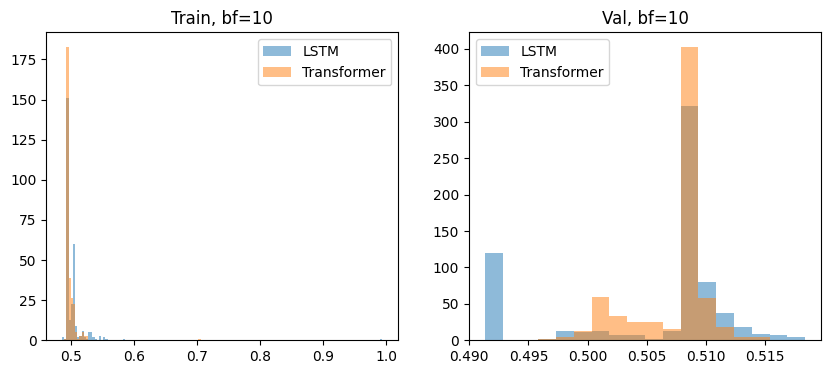

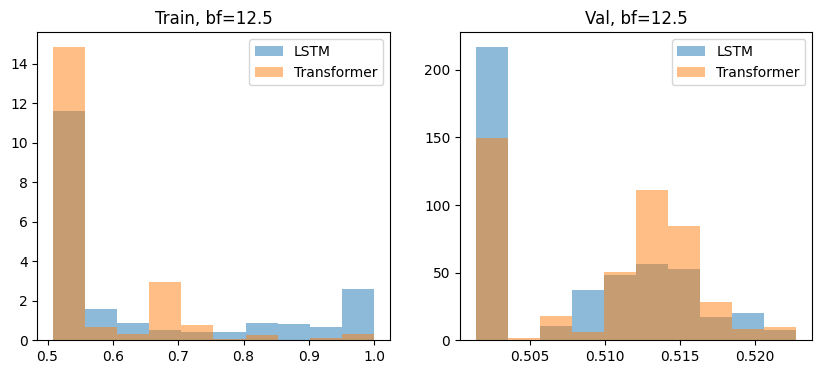

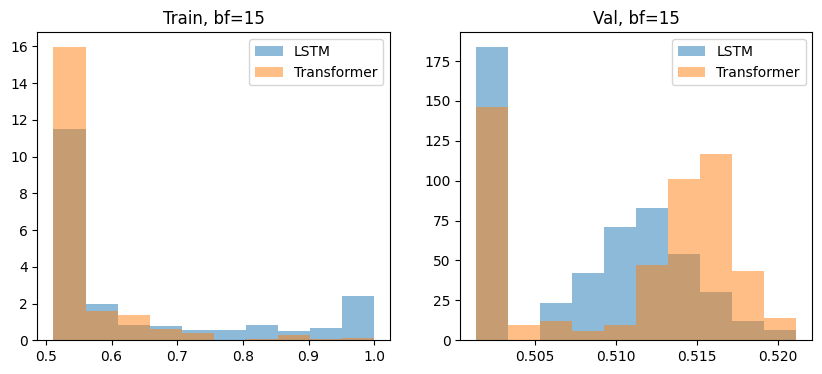

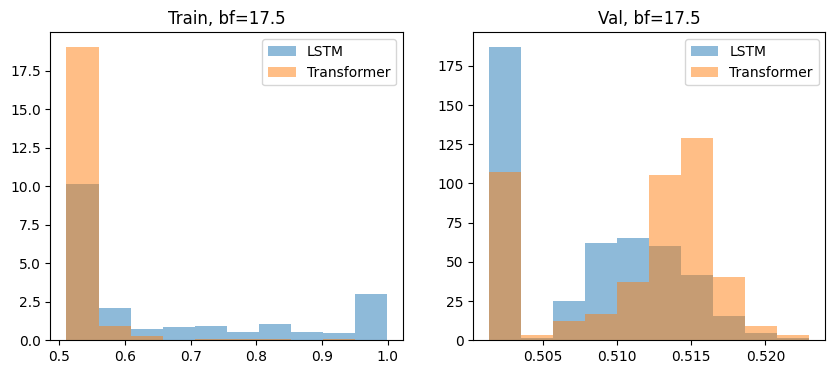

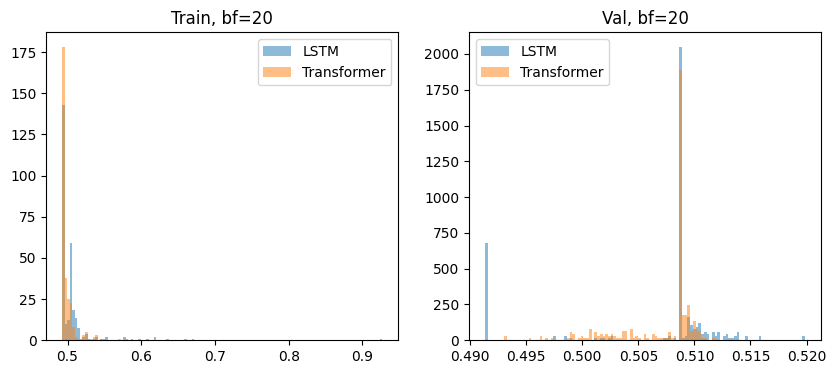

In [17]:
plt.close('all')
for bf in bf_vals:
    rnn_df = df_dct["RNN"][bf]
    san_df = df_dct["SAN"][bf]
    # histogram of training accuracies
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    train_acc_rnn = rnn_df['train_acc']
    train_acc_san = san_df['train_acc']
    val_acc_rnn = rnn_df['val_acc']
    val_acc_san = san_df['val_acc']
    gen_gap_rnn =  train_acc_rnn - val_acc_rnn
    gen_gap_san =  train_acc_san - val_acc_san


    cts, bins, _ = axes[0].hist(train_acc_rnn, bins='auto', alpha=0.5, label='LSTM', density=True)
    axes[0].hist(train_acc_san, bins=bins, alpha=0.5, label='Transformer', density=True)
    axes[0].legend()
    axes[0].set_title(f"Train, bf={bf}")

    cts, bins, _ = axes[1].hist(val_acc_rnn, bins='auto', alpha=0.5, label='LSTM', density=True)
    axes[1].hist(val_acc_san, bins=bins, alpha=0.5, label='Transformer', density=True)
    axes[1].set_title(f"Val, bf={bf}")
    axes[1].legend()